# Finding hits at the same frequency in the same sources

Noah Stiegler

7/9/24

If a source records two hits at exactly the same frequency but at two different times, we can be somewhat certain this is RFI because we think real ET signals will drift due to the doppler shifting of light based on differing accelerations between the cosmic motions of the Earth, the Sun, and the transmitting source. It would be super unlikely for these two accelerations to exactly sync up, and unless the ET source was directing a signal at Earth and deliberately trying to correct for this doppler drift with their transmission (meaning they're transmiting directly to the Earth itself directly), there will be some drift. However, with COSMIC, we can't make cuts based on a 0 drift rate signal because our resolution to detecting drift rate isn't sensitive enough to tell the difference between something drifting at a rate of 0.0000001 Hz/s (RFI likely) or something more like 0.1 Hz/s (note the smallest magnitude nonzero drift rate in the coherent hits is 0.242531920 Hz/s). However, we can artificially increase our sensitivity to low (zero) drift rates by looking for the same signal across multiple times of observation. If we see multiple hits across time at exactly the same frequencies (or within a small narrow band), then it's likely RFI.

### Setup

In [1]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_array
from scipy.sparse import lil_array
from scipy.sparse import save_npz
from scipy.sparse import load_npz
import os

In [2]:
# Read in the data

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1" or hostname == "blpc2":
    full_dataset_path = "/datax/scratch/nstieg/25GHz_higher.pkl"
    coherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_coherent.pkl"
    incoherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_incoherent.pkl"
else:
    raise Exception("Data path not known")

# Read in data
coherent = pd.read_pickle(coherent_dataset_path)
# incoherent = pd.read_pickle(incoherent_dataset_path)
# df = pd.read_pickle(full_dataset_path)

### Look for hits within each source which are at the same frequencies

In [3]:
# Set the threshold distance in hz to call two hits 'adjacent' and record their relative distances
threshold_hz = 1000
threshold = threshold_hz * 1e-6 # in MHz

##### Setup Algorithm

In [4]:
# Find adjacent points (like algorithm described above)
# data: pandas series with reset index (index goes 0...n-1 consecutively)
# window_width: width of window to find adjacency in same units as data (ie MHz and MHz)
# Returns:
# (distances, mask) tuple
# distances is a scipy sparse lil_array of float distances between adjacent points
# mask is a scipy sparse lil_array of booleans indicating whether 
def find_adjacent_distances(data, window_width):
    # Sort the data by frequency
    sdata = data.sort_values() # sfs is sorted frequencies
    # Make sure to keep track of the original indices
    original_indices = sdata.index # Maps index in sfs to index in fs

    # Setup empty arrays, indices are original indices of data
    num_hits = len(data)
    mask = lil_array((num_hits, num_hits), dtype=bool) 
    distances = lil_array((num_hits, num_hits), dtype=np.float32) 

    # Find which hits are adjacent in order. Stop if we find one that isn't
    for i, datum in enumerate(sdata):
        j = i + 1 # Index of point to compare to
        while ((j < num_hits) and # Don't index off the end of the array
               (abs(sdata.iloc[j] - datum) <= window_width)): 
            # Find coordinates in the non-sorted list
            u = original_indices[i]
            v = original_indices[j]

            # Make sure it's upper triangular (might have to flip over diagonal)
            if u > v: u, v = v, u # swap u and v
            
            # Set elements in matrix
            mask[u, v] = True
            distances[u, v] = abs(sdata.iloc[j] - datum)

            # Check next point
            j += 1

    # Return data
    return distances, mask

##### Find Adjacent Hits

In [5]:
# Find adjacent his within data for each source individually
path = "/home/nstieg/BL-COSMIC-2024-proj/frequency_adjacency/adjacent_in_each_source/" # Place to save arrays
grouped = coherent.groupby('source_name')
for source, source_data in grouped:
    # Check if we've already done this one
    distances_file_path = path + f'{source}_within_{round(threshold_hz)}hz.distances.npz'
    mask_file_path = path + f'{source}_within_{round(threshold_hz)}hz.mask.npz'
    if not (os.path.exists(distances_file_path) and os.path.exists(mask_file_path)):
        # Log progress
        print(f"Starting source [{source}]")
        
        # Compute results
        frequencies = source_data["signal_frequency"].copy().reset_index(drop=True)
        distances, mask = find_adjacent_distances(frequencies, threshold)
        
        # Save results to file
        save_npz(distances_file_path, csr_array(distances))
        save_npz(mask_file_path, csr_array(mask))

### Analyze Adjacent Hits


In [3]:
# Load in all the distances and masks to a np array of [[distances, mask], ...] for each source
path = "/home/nstieg/BL-COSMIC-2024-proj/frequency_adjacency/adjacent_in_each_source/" # Place to save arrays
files = os.listdir(path) # All the files and directories in the folder
files = [f for f in files if os.path.isfile(path + '/' + f)] # Just get the folders
files = [f.split('.') for f in files] # Take off the extension
files = np.array(files) # Turn into a numpy array so I can slice off the extensions
files = np.unique(files[:, 0]) # Get the unique filenames (sources observed)
sources_data = [] # Append (source.distances.npz, source.mask.npz)
sources = []
for file in files:
    distances = load_npz(path + "/" + file + ".distances.npz")
    mask = load_npz(path + "/" + file + ".mask.npz")
    sources_data.append((distances, mask))
    sources.append(file.split('_')[0])

sources_data = np.array(sources_data, dtype='object')

#### Look at the first source

In [4]:
# Look at first source
# Sources are loaded in alphabetically
source_to_look_at = 0
distances = sources_data[source_to_look_at, 0]
mask = sources_data[source_to_look_at, 1]
print(sources[source_to_look_at])
grouped = coherent.groupby('source_name')
first_source = grouped.get_group(sources[source_to_look_at]).reset_index(drop=True)
print(first_source.shape) 
print(distances.shape)
print(mask.shape)

2535280716217508992
(51451, 14)
(51451, 51451)
(51451, 51451)


In [5]:
first_source.reset_index()

,index,id,signal_frequency,signal_drift_rate,signal_snr,signal_beam,signal_power,signal_incoherent_power,signal_num_timesteps,tstart,tstart_h,ra_hours,dec_degrees,source_name,tuning
0,0,987212100,33262.648879,-0.242532,28.487003,0,2.522037e+12,2.511025e+12,16,60307.159461,2023-12-29 03:49:37.462265,1.289133,0.944188,2535280716217508992,AC
1,1,987212101,33262.714699,-0.242532,18.348831,0,1.737750e+12,1.657623e+12,16,60307.159461,2023-12-29 03:49:37.462265,1.289133,0.944188,2535280716217508992,AC
2,2,987212102,33262.708600,0.000000,9.762711,0,1.073530e+12,1.160607e+12,16,60307.159461,2023-12-29 03:49:37.462265,1.289133,0.944188,2535280716217508992,AC
3,3,987212103,33263.373025,0.000000,12.425972,0,1.279559e+12,1.091837e+12,16,60307.159461,2023-12-29 03:49:37.462265,1.289133,0.944188,2535280716217508992,AC
4,4,987212104,33263.247551,0.000000,10.586574,0,1.137264e+12,1.148512e+12,16,60307.159461,2023-12-29 03:49:37.462265,1.289133,0.944188,2535280716217508992,AC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51446,51446,987304905,32336.927357,34.439533,8.252510,0,4.409588e+11,1.973376e+11,16,60307.185474,2023-12-29 04:27:04.954078,1.289133,0.944188,2535280716217508992,BD
51447,51447,987304906,32334.951907,-38.320043,8.577608,0,4.496001e+11,2.063336e+11,16,60307.185474,2023-12-29 04:27:04.954078,1.289133,0.944188,2535280716217508992,BD
51448,51448,987304907,32333.765336,-9.701277,8.194855,0,4.343808e+11,1.928548e+11,16,60307.185474,2023-12-29 04:27:04.954078,1.289133,0.944188,2535280716217508992,BD
51449,51449,987304908,32331.986439,41.230426,8.122281,0,4.276111e+11,1.930812e+11,16,60307.185474,2023-12-29 04:27:04.954078,1.289133,0.944188,2535280716217508992,BD


<Axes: xlabel='tstart_h', ylabel='signal_frequency'>

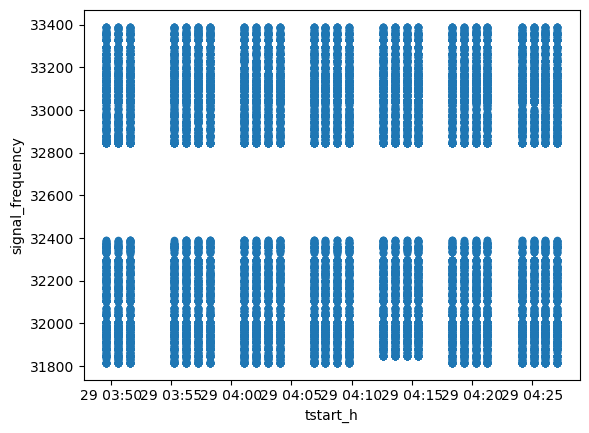

In [6]:
first_source.plot.scatter("tstart_h", "signal_frequency")

In [7]:
# Figure out how many 'collisions' there are
print(f"There are {np.sum(mask)} collisions in this file")

There are 499607 collisions in this file


There are 260849 collisions in the file with a distance of 0Hz
There are 487001 collisions in the file with a distance of 100Hz


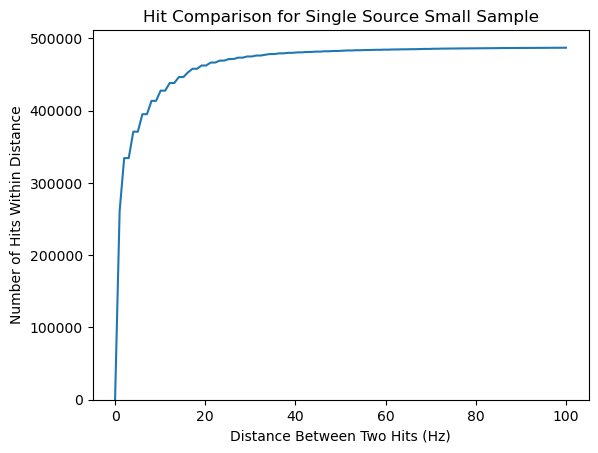

In [8]:
# Look at about how many are within certain frequencies
print(f"There are {(distances[mask] == 0).sum()} collisions in the file with a distance of 0Hz")
print(f"There are {(distances[mask] <= 100e-6).sum()} collisions in the file with a distance of 100Hz")

xaxis = np.linspace(-0.001, 100, 100)
yaxis = np.array([(distances[mask] <= frequency_threshold*1e-6).sum() for frequency_threshold in xaxis])

plt.plot(xaxis, yaxis)
plt.xlabel("Distance Between Two Hits (Hz)")
plt.ylabel("Number of Hits Within Distance")
plt.title("Hit Comparison for Single Source Small Sample")
plt.ylim(bottom=0)
plt.show()

There are 260849 collisions in the file with a distance of 0Hz
There are 487001 collisions in the file with a distance of 100Hz


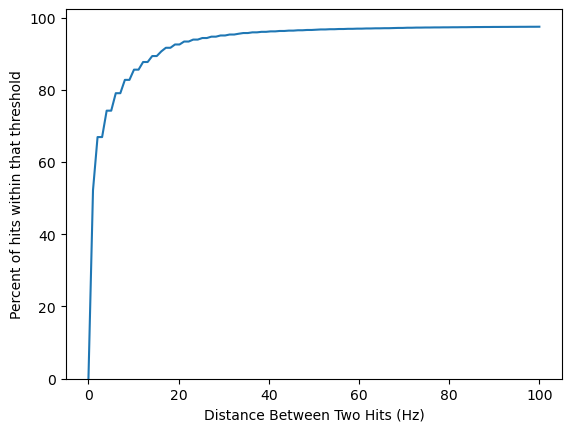

In [10]:
# Look at about how many are within certain frequencies
print(f"There are {(distances[mask] == 0).sum()} collisions in the file with a distance of 0Hz")
print(f"There are {(distances[mask] <= 100e-6).sum()} collisions in the file with a distance of 100Hz")

xaxis = np.linspace(-0.001, 100, 100)
yaxis = np.array([(distances[mask] <= frequency_threshold*1e-6).sum() for frequency_threshold in xaxis])

plt.plot(xaxis, yaxis / np.sum(mask) * 100)
plt.xlabel("Distance Between Two Hits (Hz)")
plt.ylabel("Percent of hits within that threshold")
plt.ylim(bottom=0)
plt.show()

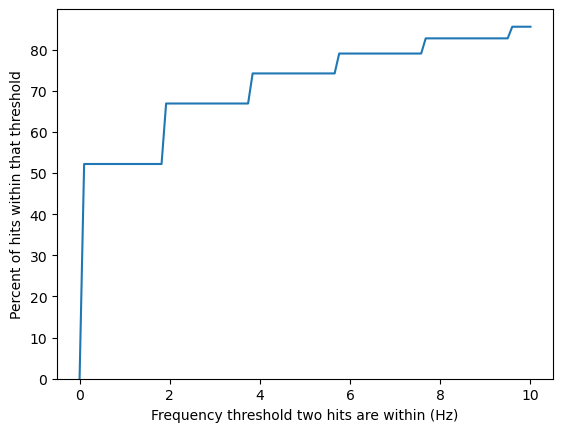

In [11]:
xaxis = np.linspace(-0.001, 10, 100)
yaxis = np.array([(distances[mask] <= frequency_threshold*1e-6).sum() for frequency_threshold in xaxis])

plt.plot(xaxis, yaxis / np.sum(mask) * 100)
plt.xlabel("Frequency threshold two hits are within (Hz)")
plt.ylabel("Percent of hits within that threshold")
plt.ylim(bottom=0)
plt.show()

In [12]:
# Let's look at how many collisions there were within a threshold
# Want to do (distances <= threshold) & mask to get all the values which are under the threshold
# including zeroes which are let in by the mask
# However, if we turn all the 0s in the sparse array to Trues, it's not sparse anymore (so it's super slow)
# So how do we maintain the sparsity?
# Well, we can look for the opposite first, the values which are outside the threshold
# Then we can remove those from the mask so there's a new mask just contains the values we care about below the threshold 
# Then the number of collisions within that threshold is the number of Trues in the new mask
# And if we want to get those distances (or the hits which are close to each other), then we can do distances[new_mask] (or new_mask.nonzero())
def find_collisions_at_threshold(threshold):
    # Get those outside threshold
    outside_threshold = distances > threshold

    # Remove those outside threshold from the mask
    # We want to do mask & (~outside_threshold), but note that ~outside_threshold produces an array which is mostly true
    # So instead we'll have to do mask - outside_threshold 
    # (which does xor, so it will have values which are in mask but not outside_threshold, and those in outside_threshold but not mask)
    # Finally, to get rid of values in outside_threshold but not mask, we'll and by mask
    new_mask = mask.multiply(mask - outside_threshold)

    return new_mask

In [13]:
## Confirm the result with how many distances are zero
# Set threshold
threshold_hz = 0
threshold = threshold_hz * 1e-6
new_mask = find_collisions_at_threshold(threshold)
print(new_mask.sum())

260849


In [14]:
## Confirm the result with how many distances are <= 100Hz
# Set threshold
threshold_hz = 100
threshold = threshold_hz * 1e-6
new_mask = find_collisions_at_threshold(threshold)
print(new_mask.sum())

487001


In [15]:
# See how many hits did vs. didn't have another hit within 1000hz
num_hits_with_associated_hit = len(np.unique(np.concatenate(mask.nonzero())))
print(f"{num_hits_with_associated_hit} hits had another hit within {1000}Hz out of {len(first_source)} hits ({num_hits_with_associated_hit / len(first_source) * 100}%)")

41034 hits had another hit within 1000Hz out of 51451 hits (79.75355192318906%)


In [16]:
# See how many hits did vs. didn't have another hit at exactly the same frequency
same_frequency = find_collisions_at_threshold(0)
num_same_frequency = len(np.unique(np.concatenate(same_frequency.nonzero())))
print(f"{num_same_frequency} hits had another hit within {0}Hz out of {len(first_source)} hits ({num_same_frequency / len(first_source) * 100}%)")

36159 hits had another hit within 0Hz out of 51451 hits (70.2785174243455%)


In [14]:
# See how many associated hits each hit has
associated_hits_for_each_hit = [mask[:, i].sum() + mask[i, :].sum() for i in range(len(first_source))]

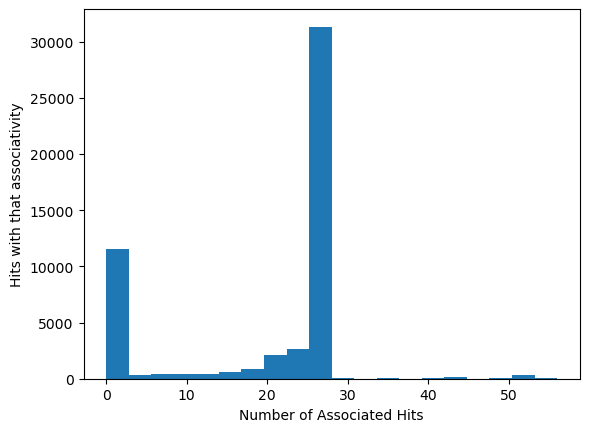

In [ ]:
plt.hist(associated_hits_for_each_hit, bins=20)
plt.xlabel("Number of Associated Hits")
plt.ylabel("Hits with that associativity")
plt.show()

In [ ]:
# Figure out what the most connected ones are
print("The maximum number of associations a hit has is ", max(associated_hits_for_each_hit))
print("And that hit (or those hits):", np.where(associated_hits_for_each_hit == max(associated_hits_for_each_hit))[0])
print("The minimum number of associations a hit has is ", min(associated_hits_for_each_hit))

The maximum number of associations a hit has is  56
And that hit (or those hits): [  294  3236  6027  9016 11165 12632 14413 15987 20059 21340 24455 25193
 28198 28948 31960 33295 35538 36852 38334 40153 43084 47111 47785 51134]
The minimum number of associations a hit has is  0


##### Investigate those with a distance of 0

In [18]:
# Get hits at the exact same frequency
same_frequency = find_collisions_at_threshold(0)

# Get their indices (which tell us what row of of the hits file to look for them in)
hit_indices = same_frequency.nonzero()
print(hit_indices)
print(hit_indices[0].shape)

(array([    2,     2,     2, ..., 49544, 49545, 49546], dtype=int32), array([ 3462,  5276,  5896, ..., 49918, 49919, 49920], dtype=int32))
(260849,)


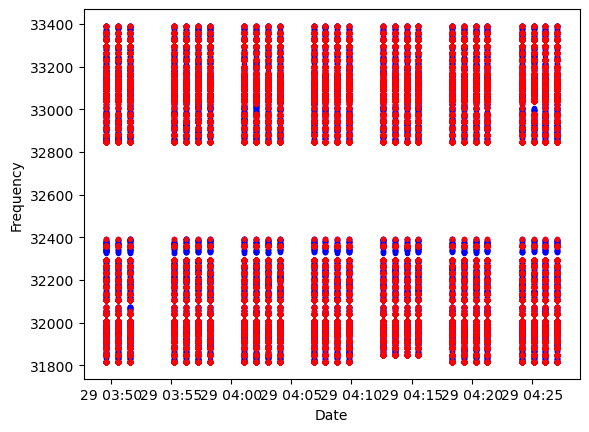

In [19]:
# Look at where they are with respect to all the data

# Plot all data
xaxis = first_source["tstart_h"]
yaxis = first_source["signal_frequency"]
plt.scatter(xaxis, yaxis, marker='.', color='blue')

# Plot just the hits which are the exact same as another hit
zero_distance_dataset = first_source.iloc[np.unique(np.concatenate(hit_indices))]
xaxis = zero_distance_dataset["tstart_h"]
yaxis = zero_distance_dataset["signal_frequency"]
plt.scatter(xaxis, yaxis, marker='.', color='red')

plt.xlabel("Date")
plt.ylabel("Frequency")
plt.show()

In [20]:
# So I'm seeing that the hit at index 2 is at the same frequency as several other hits. Let's just look at that
hit_index_to_look_at = 2
hit_index_to_look_at_freq = first_source["signal_frequency"][hit_index_to_look_at]
print("Hit", hit_index_to_look_at, "at", hit_index_to_look_at_freq, "MHz")
other_hit_indices = hit_indices[1][np.where(hit_indices[0] == hit_index_to_look_at)]
print("Same frequency as", other_hit_indices)

Hit 2 at 33262.708599607846 MHz
Same frequency as [ 3462  5276  5896  7851 10236 12117 13656 16318 17528 20712 21869 24006
 25464 27395 30077 31744 33932 34850 36884 38190 40533 41901 44528 49312
 49651]


In [21]:
# Just to be sure, let's print out all the frequencies and make sure they're the same
for i in other_hit_indices:
    this_frequency = first_source["signal_frequency"][i]
    assert(this_frequency == hit_index_to_look_at_freq)
    # print(this_frequency)

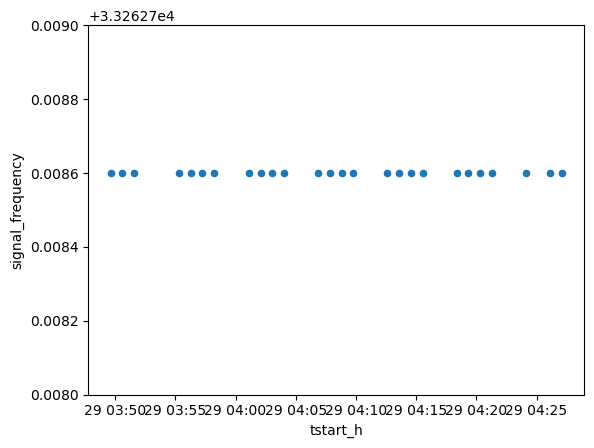

In [29]:
# Let's make a dataset that just has these points to mess around with
indices = np.concatenate(([hit_index_to_look_at], other_hit_indices))
small_dataset = first_source.iloc[indices]
small_dataset.plot.scatter("tstart_h", "signal_frequency")
plt.ylim([33262.708, 33262.709])
plt.show()

In [23]:
# So they really are the same frequency detected at different times!
# Let's see if any are the same frequency detected at the same time
print("There are", (small_dataset.groupby("tstart").size() > 1).sum(), "times with multiple hits")

There are 0 times with multiple hits


In [24]:
small_dataset.columns

Index(['id', 'signal_frequency', 'signal_drift_rate', 'signal_snr',
       'signal_beam', 'signal_power', 'signal_incoherent_power',
       'signal_num_timesteps', 'tstart', 'tstart_h', 'ra_hours', 'dec_degrees',
       'source_name', 'tuning'],
      dtype='object')

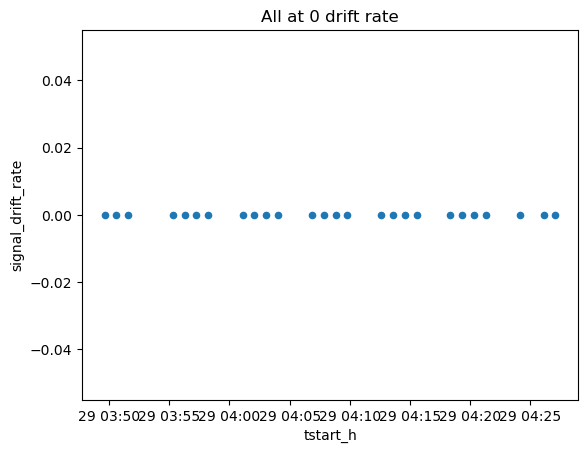

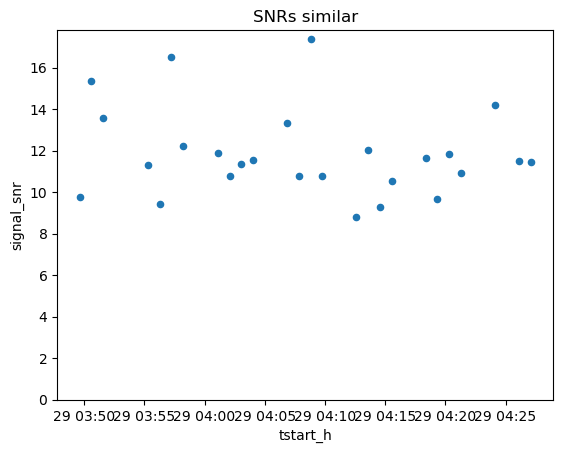

In [25]:
# Let's look at other properties of the dataset
small_dataset.plot.scatter("tstart_h", "signal_drift_rate") 
plt.title("All at 0 drift rate")
plt.show()

small_dataset.plot.scatter("tstart_h", "signal_snr")
plt.ylim(bottom=0)
plt.title("SNRs similar")
plt.show()

In [26]:
# Were any of these signals detected with nonzero drift rate?
indices_of_nonzero_dr = zero_distance_dataset["signal_drift_rate"] != 0
print(indices_of_nonzero_dr.sum(), "signals with nonzero drift rate of", len(zero_distance_dataset), f"({round(indices_of_nonzero_dr.sum() / len(zero_distance_dataset) * 100, 2)}%)")
print("So most were detected with a zero drift rate")

3815 signals with nonzero drift rate of 36159 (10.55%)
So most were detected with a zero drift rate


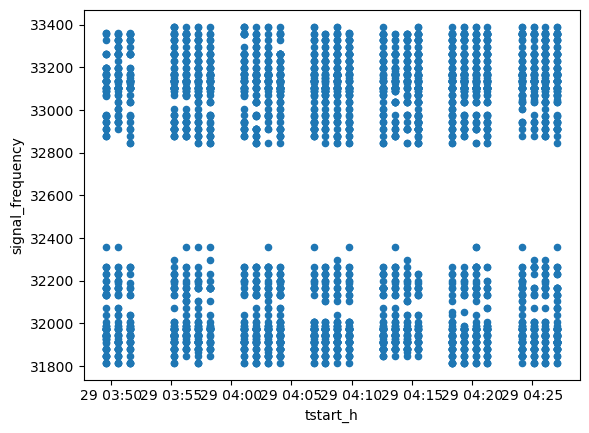

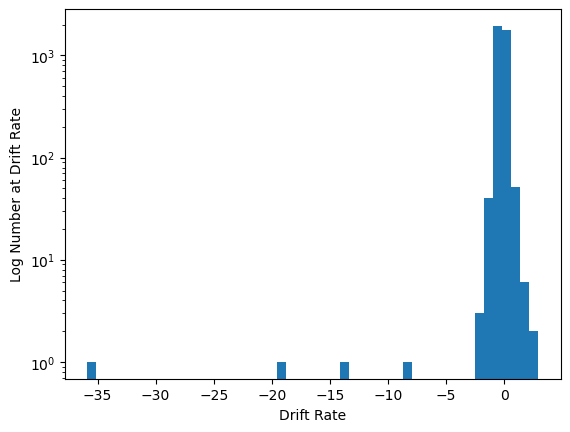

In [27]:
# Let's look at those nonzero drift rate signals
nonzero_dr_database = zero_distance_dataset[indices_of_nonzero_dr]
nonzero_dr_database.plot.scatter("tstart_h", "signal_frequency")
plt.show()
plt.hist(nonzero_dr_database["signal_drift_rate"], bins=50)
plt.yscale("log")
plt.xlabel("Drift Rate")
plt.ylabel("Log Number at Drift Rate")
plt.show()